In [1]:
%matplotlib inline

import json
import re
import urllib
from pprint import pprint
import time
from tqdm import tqdm

from py2neo import Node, Graph, Relationship, NodeMatcher
from py2neo.bulk import merge_nodes

import numpy as np
import pandas as pd

from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.metrics import ConfusionMatrixDisplay

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

In [2]:
# If you are using a Docker container for your DB, use the uncommented line.
# graph = Graph("bolt://some_ip_address:7687", name="neo4j", password="some_password")

uri = ''
user = 'neo4j'
pwd = ''

graph = Graph(uri, auth=('neo4j', pwd))
nodes_matcher = NodeMatcher(graph)

In [3]:
pbo_ls = []
pbo = graph.run('MATCH (n:Node {name: "u.s"})--(m) RETURN DISTINCT m.name')
for record in pbo:
    pbo_ls.append(record[0])
print('Total number of connected nodes: ', len(pbo_ls))
pbo_ls

Total number of connected nodes:  1


['missouri']

In [4]:
obm_ls = []
obm = graph.run('MATCH (n:Node {name: "united states"})--(m) RETURN DISTINCT m.name')
for record in obm:
    obm_ls.append(record[0])
print('Total number of connected nodes: ', len(obm_ls))
print(obm_ls)

Total number of connected nodes:  29
['settlers', 'white americans', 'midwestern united states', 'kansas', 'maryland', 'federal government', 'territory', 'verdigris river', 'texas', 'state', 'mexican american war', 'tennessee', 'kansas river', '1890s', 'missouri river', 'north america', '50 states', 'european americans', 'mexico', 'virginia', 'country', 'louisiana', 'louisiana purchase', 'missouri compromise', 'missouri', 'american civil war', 'america', 'slave state', 'american english']


In [5]:
pbo_set = set(pbo_ls)
obm_set = set(obm_ls)
#if (pbo_set & obm_set):
print('Number of overlapping elements: ', len(pbo_set & obm_set))
print('Percent of overlapping elements: ', len(pbo_set & obm_set)/len(pbo_ls))
print(pbo_set & obm_set)

Number of overlapping elements:  1
Percent of overlapping elements:  1.0
{'missouri'}


In [29]:
df = graph.run('MATCH (n:Node) RETURN n.name, n.node_labels, n.pptu_person, n.pptu_place, n.pptu_thing, n.pptu_unknown, n.word_vec, n.n2v_all_nodes').to_data_frame()
df.columns = ['name', 'node_labels', 'pptu_person', 'pptu_place', 
              'pptu_thing', 'pptu_unknown', 'word_vec', 'n2v_all_nodes']
df2 = df.fillna(0)
df2.head(50)

,name,node_labels,pptu_person,pptu_place,pptu_thing,pptu_unknown,word_vec,n2v_all_nodes
0,east bank,"[Thing, Corporation, Organization]",1.0,0.0,1.0,0.0,"[-2.532848596572876, -1.29244065284729, -0.456...","[-2.142038106918335, 0.07322903722524643, -0.0..."
1,lower missouri valley,[],0.0,0.0,0.0,1.0,"[0.6099934708033348, -0.12298563608965263, -0....","[-1.728474497795105, 0.40080299973487854, -0.5..."
2,early 1700s,[],0.0,0.0,0.0,1.0,"[0.48508472172346906, -0.6531352496536069, 0.4...","[-1.7556642293930054, 0.12853214144706726, -0...."
3,mississippi valley,"[Thing, Organization, Corporation]",1.0,0.0,1.0,0.0,"[-2.7624733448028564, -0.7828894257545471, -1....","[-1.790657639503479, 0.2543518543243408, -0.60..."
4,region,[Thing],0.0,0.0,1.0,0.0,"[-3.843702554702759, -1.770546317100525, -2.60...","[-1.530823826789856, -0.1545102298259735, -0.4..."
5,french canadians,[Thing],0.0,0.0,1.0,0.0,"[-3.485438108444214, 0.8641850352287292, -1.30...","[-1.6785918474197388, -0.16820566356182098, -1..."
6,villages,"[Thing, Place]",0.0,1.0,1.0,0.0,"[-2.146040916442871, -0.9722490310668945, -1.4...","[-0.9165279269218445, -0.07925008237361908, 0...."
7,settlements,"[Thing, Country, Place, AdministrativeArea]",0.0,1.0,1.0,0.0,"[-2.509780168533325, -1.1984837055206299, -1.5...","[-1.7747530937194824, 0.3858017027378082, -0.1..."
8,le,"[Thing, Corporation, Organization, SportsOrgan...",1.0,0.0,1.0,0.0,"[-3.050610065460205, -1.662542462348938, -1.34...","[-1.8486310243606567, -0.29010480642318726, -0..."
9,des illinois,"[Thing, Place, City, AdministrativeArea]",0.0,1.0,1.0,0.0,"[-3.300793409347534, -0.523457407951355, -1.04...","[-1.877923607826233, 0.24181011319160461, -0.1..."


In [7]:
def create_X(df2):

    word_vec_ls = df2['word_vec'].to_list()
    word_vec_arr = np.array([np.array(x) if x != 0 else np.zeros(300).tolist() for x in word_vec_ls], dtype=object)

    n2v_an_ls = df2['n2v_all_nodes'].to_list()
    n2v_arr = np.array([np.array(x) for x in n2v_an_ls], dtype=object)

    print(word_vec_arr.shape, n2v_arr.shape)
    
    return word_vec_arr, n2v_arr

In [8]:
X_word_vec, X_all_nodes = create_X(df2)

(1696, 300) (1696, 10)


In [9]:
X_word_vec

array([[-2.532848596572876, -1.29244065284729, -0.456695556640625, ...,
        -1.9489233493804932, -1.794289231300354, 1.2736297845840454],
       [0.6099934708033348, -0.12298563608965263, -0.22689407155583163,
        ..., -0.25286154640126, -0.956605661946033, -0.7380467924319072],
       [0.48508472172346906, -0.6531352496536069, 0.4452338398997655,
        ..., 0.8826881468821419, 0.29121593522104283,
        -0.40592353235604706],
       ...,
       [0.0, 0.0, 0.0, ..., 0.0, 0.0, 0.0],
       [0.0, 0.0, 0.0, ..., 0.0, 0.0, 0.0],
       [0.0, 0.0, 0.0, ..., 0.0, 0.0, 0.0]], dtype=object)

In [10]:
X_all_nodes

array([[-2.142038106918335, 0.07322903722524643, -0.004316974896937609,
        ..., 0.3095172047615051, 0.3061204254627228,
        -0.04537481442093849],
       [-1.728474497795105, 0.40080299973487854, -0.5574244856834412,
        ..., 0.5247741937637329, 0.5325940251350403, -0.277439147233963],
       [-1.7556642293930054, 0.12853214144706726, -0.12561115622520447,
        ..., 0.555700957775116, 0.6890303492546082, -0.4461764395236969],
       ...,
       [-0.7094574570655823, -0.6117875576019287, 0.836877167224884, ...,
        0.9691661596298218, 1.097043514251709, 1.4866772890090942],
       [-1.0510854721069336, 0.3234264850616455, 1.4763728380203247, ...,
        1.8684417009353638, 1.7473071813583374, 0.7633427977561951],
       [-1.1226130723953247, 0.7108118534088135, 1.4251840114593506, ...,
        2.2868494987487793, 3.2671360969543457, -0.3174508213996887]],
      dtype=object)

In [18]:
def modeler(df, column_name, X, k_folds=5, model='linear', show_matrix=True):
    
    y = df[column_name].fillna(0.0).to_numpy()
    acc_scores = []
    
    pos = np.count_nonzero(y == 1.0)
    neg = y.shape[0] - pos
    print('Number of positive: ', pos, ' Number of negative: ', neg)
    
    for i in range(0, k_folds):
        
        X_train, X_test, y_train, y_test = train_test_split(X_word_vec, y, test_size=0.25)
        clf = svm.SVC(kernel='rbf')
        clf.fit(X_train, y_train)
        pred = clf.predict(X_test)

        acc = accuracy_score(pred, y_test)
        acc_scores.append(acc)        
        
    print('Accuracy scores: ', acc_scores)
    print('Mean accuracy: ', np.mean(acc_scores))
    
    if show_matrix:
        matrix = ConfusionMatrixDisplay.from_estimator(clf, X_test, y_test, cmap=plt.cm.Blues, normalize='true')
        plt.show(matrix)
        plt.show()
        
    return

Number of positive:  317  Number of negative:  1379
Accuracy scores:  [0.9316037735849056, 0.9481132075471698, 0.9528301886792453, 0.9316037735849056, 0.9551886792452831]
Mean accuracy:  0.9438679245283017


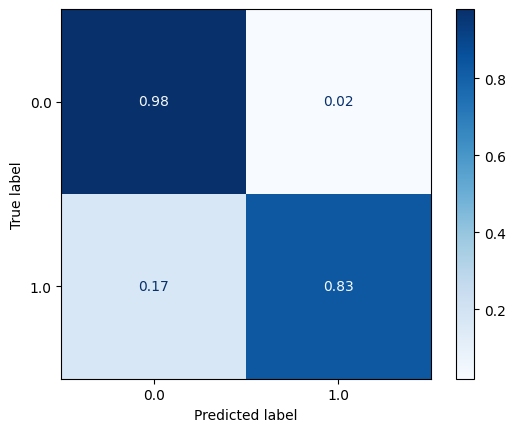

CPU times: user 848 ms, sys: 37.6 ms, total: 886 ms
Wall time: 807 ms


In [19]:
%%time
modeler(df2, 'pptu_person', X_word_vec)

Number of positive:  317  Number of negative:  1379
Accuracy scores:  [0.9080188679245284, 0.9268867924528302, 0.9339622641509434, 0.9433962264150944, 0.9080188679245284]
Mean accuracy:  0.9240566037735849


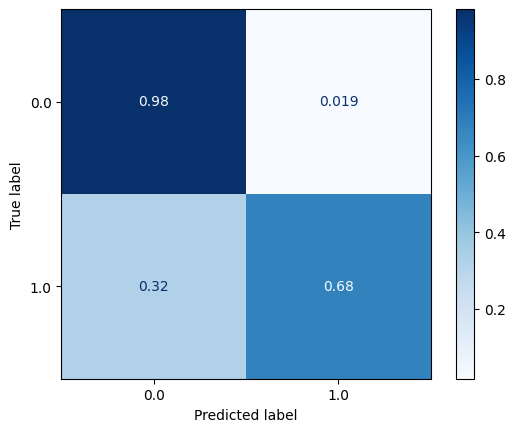

CPU times: user 889 ms, sys: 44 ms, total: 933 ms
Wall time: 856 ms


In [20]:
%%time
modeler(df2, 'pptu_person', X_all_nodes)

Number of positive:  251  Number of negative:  1445
Accuracy scores:  [0.9575471698113207, 0.9693396226415094, 0.9481132075471698, 0.9575471698113207, 0.9433962264150944]
Mean accuracy:  0.9551886792452831


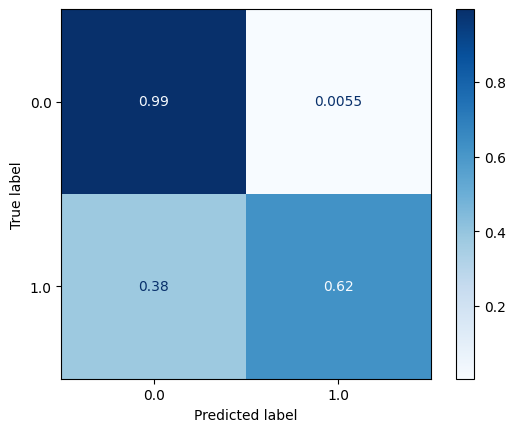

CPU times: user 680 ms, sys: 11.6 ms, total: 691 ms
Wall time: 607 ms


In [21]:
%%time
modeler(df2, 'pptu_place', X_word_vec)

Number of positive:  251  Number of negative:  1445
Accuracy scores:  [0.9386792452830188, 0.9551886792452831, 0.9551886792452831, 0.964622641509434, 0.9622641509433962]
Mean accuracy:  0.9551886792452831


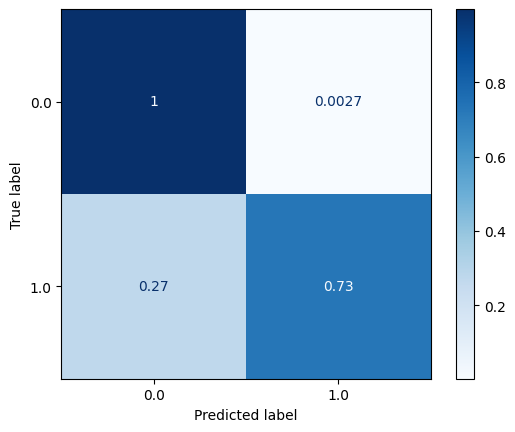

CPU times: user 675 ms, sys: 10.8 ms, total: 686 ms
Wall time: 601 ms


In [22]:
%%time
modeler(df2, 'pptu_place', X_all_nodes)

Number of positive:  1312  Number of negative:  384
Accuracy scores:  [0.9433962264150944, 0.9457547169811321, 0.9575471698113207, 0.9481132075471698, 0.9339622641509434]
Mean accuracy:  0.945754716981132


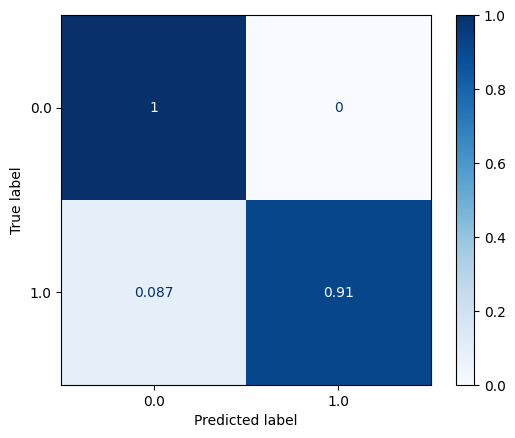

CPU times: user 608 ms, sys: 9.64 ms, total: 618 ms
Wall time: 519 ms


In [23]:
%%time
modeler(df2, 'pptu_thing', X_word_vec)

Number of positive:  1312  Number of negative:  384
Accuracy scores:  [0.9339622641509434, 0.9504716981132075, 0.9481132075471698, 0.9504716981132075, 0.9481132075471698]
Mean accuracy:  0.9462264150943396


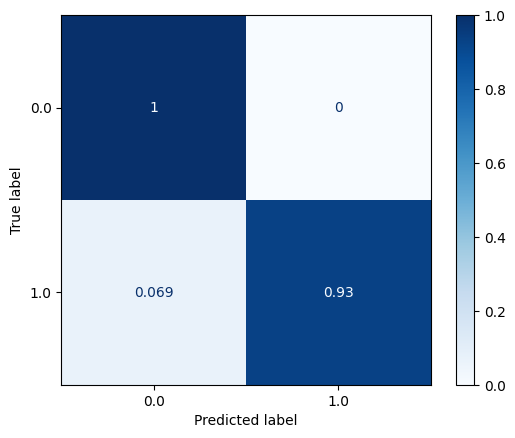

CPU times: user 973 ms, sys: 7.64 ms, total: 981 ms
Wall time: 477 ms


In [24]:
%%time
modeler(df, 'pptu_thing', X_all_nodes)